# CMRM Homework Assignment No. 1 (HW1)

In [6]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import deeplake 
from tqdm import tqdm
from sklearn import preprocessing
from sklearn import svm
from sklearn import metrics
import pickle
import IPython.display as ipd

## Question 1

In [7]:
# Import dataset
ds = deeplake.load("hub://activeloop/gtzan-genre")

-

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/gtzan-genre



-

hub://activeloop/gtzan-genre loaded successfully.



In [8]:

audio_tensor = ds['audio'] 
genre_tensor = ds['genre'] 
print(audio_tensor.shape)
print(genre_tensor.shape)



(1000, None, 1)
(1000, 1)


In [9]:
Fs = 22050
n_samples = 29 * Fs # duration in samples 
n_wav = len(audio_tensor) # number of samples

genre_names = ['pop', 'metal', 'classical', 'rock', 'blues', 'jazz', 'hiphop', 'reggae', 'disco', 'country']
id2label = {id: label for id, label in enumerate(genre_names)}

# Define downsampling factors
sub_train = 10
sub_test = 52

# Extract classes
samples = genre_tensor.numpy()
samples = samples.flatten().tolist()

genre_train =np.array([id2label[samples[x]] for x in range(0, n_wav, sub_train)]) 
genre_test = np.array([id2label[samples[x]] for x in range(11, n_wav, sub_test)])

print(np.shape(genre_train)) #(100, 1)
print(np.shape(genre_test)) #(20, 1)


# Extract training set
audio_train = []
for i in tqdm(range(0, n_wav, sub_train)):
    audio_train.append(audio_tensor[i].data()['value'][0:n_samples][:, 0])


# Extract test set
audio_test = []
for i in tqdm(range(11, n_wav, sub_test)):
    audio_test.append(audio_tensor[i].data()['value'][0:n_samples][:, 0])


audio_train = np.array(audio_train)
audio_test = np.array(audio_test)
print(np.shape(audio_train)) #(100, 639450)
print(np.shape(audio_test)) #(20, 639450)

(100,)
(20,)


 10%|█         | 10/100 [00:30<04:45,  3.17s/it]/Users/juanmirko/Desktop/computer music/CMRM-HWA1/cmrm_project_venv/lib/python3.9/site-packages/deeplake/core/tensor.py:705: UserWarning: Indexing by integer in a for loop, like `for i in range(len(ds)): ... ds.tensor[i]` can be quite slow. Use `for i, sample in enumerate(ds)` instead.
  warnings.warn(
100%|██████████| 20/20 [00:46<00:00,  2.30s/it]


(100, 639450)
(20, 639450)


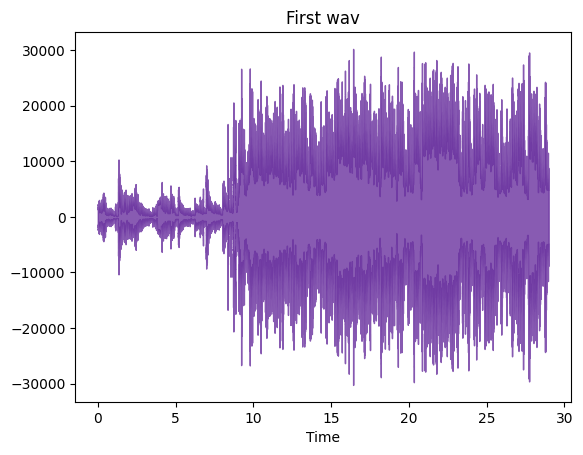

In [10]:
librosa.display.waveshow(audio_train[0], alpha=0.8, color="#6A329F")
plt.title("First wav")

#Check if samples are ok
ipd.display(ipd.Audio(data=audio_train[0], rate=Fs))


## Question 2

In [11]:
# Preprocessing

scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
audio_train = scaler.fit_transform(audio_train)
audio_test = scaler.transform(audio_test)

Text(0.5, 1.0, 'Normalized first wav')

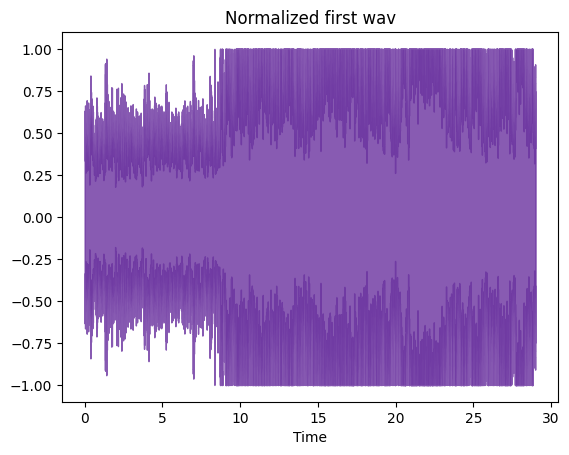

In [12]:
# Plot the first wav in the train set after preprocessing
librosa.display.waveshow(audio_train[0], alpha=0.8, color="#6A329F")
plt.title("Normalized first wav")

In [13]:
# Compute local average

def compute_local_average(x, M):
    """Compute local average of signal
      
    Args:
        x: signal 
        M: window len in samples 
        
    Returns:
        y: np.array with local average 
    """
    L = len(x)
    local_average = np.zeros(L)
    for n in range(L):
        a = max(n - M, 0)
        b = min(n + M + 1, L)
        local_average[n] = (1 / (2 * M + 1)) * np.sum(x[a:b])
    return local_average

# Compute the principal argument
def principal_argument(x):
    """Principal argument function 
    
    Args:
        x: value (or vector of values) 
        
    Returns:
        y: Principal value of x

    """

    y = np.mod(x + 0.5, 1) - 0.5

    return y


def compute_phase_novelty(x, Fs=1, N=1024, H=64, M=40, norm=True, plot=False):
    """Compute phase-based novelty function

    Args:
        x: Signal
        Fs: Sampling rate
        N: Window size
        H: Hop size
        M: Total length in samples of centric window  used for local average
        norm: Apply max norm (if norm==True)
        plot: plot novelty (if plot==True)

    Returns:
        nov: Phase-based novelty function
        Fs_nov: Novelty rate
    """
    
    # Compute the STFT
    zxx = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann')

    # Compute the novelty rate
    novelty_fs = Fs / H

    # Extract and normalize the phase
    phi = np.angle(zxx) / (2 * np.pi)

    # Compute the first derivative and apply principal_argument function
    phi_prime = np.diff(phi, axis=1) #axis 1 = x axis
    phi_prime = principal_argument(phi_prime) 
    
    # Compute the second derivative
    phi_double_prime = np.diff(phi_prime, axis=1)
    phi_double_prime = principal_argument(phi_double_prime) 
    
    # Accumulation over the frequency axis
    novelty = np.sum(np.abs(phi_double_prime), axis=0)
    novelty = np.concatenate((novelty, np.array([0, 0])))

    # Subtract local average and apply half-wave rectification
    if M > 0:
        local_average = compute_local_average(novelty, M)
        
        novelty = novelty - local_average
        novelty[novelty < 0] = 0.0

    # Apply normalization if requested
    if norm:
        max_value = np.max(novelty)
        if max_value > 0:
            novelty = novelty / max_value

    # Plot the novelty function if requested
    if plot:
        feature_time_axis = np.arange(novelty.shape[0]) / novelty_fs
        plt.plot(feature_time_axis, novelty, color="#6A329F", alpha=0.9)
        plt.title('Phase Novelty')
        plt.xlabel('Time')
        plt.ylabel('Novelty')
        plt.show()

    return novelty, novelty_fs
    


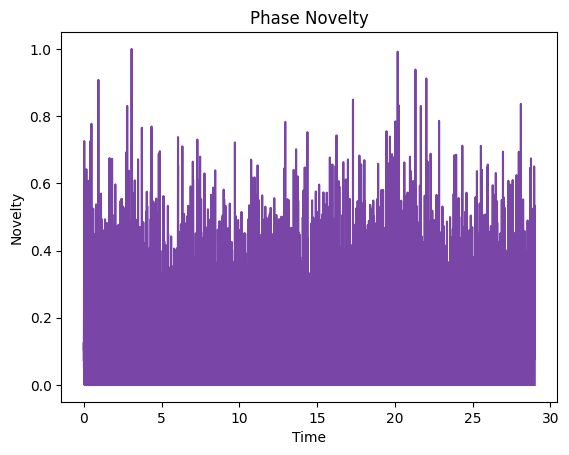

In [14]:
# Test the novelty function on the first wav in the train set

n, fs_n = compute_phase_novelty(audio_train[0], Fs, H=32, plot=True)


## Question 3

In [15]:
def compute_feature_vector(x, Fs, N=2048, H=128):
    """Compute the feature vector 

    Args:
        x: Input signal
        Fs: Sampling rate
        N: Window length
        H: Hop size

    Returns:
        f_vector: Feature vector
    """

    # Compute rhythmic features
    n, fs_n = compute_phase_novelty(x, Fs, N, H)
    n_std = np.std(n)
    n_mean = np.mean(n)

    oenv = librosa.onset.onset_strength(y=n, sr=Fs)
    tempogram = librosa.feature.tempogram(y=n, sr=fs_n, win_length=N, hop_length=H, onset_envelope=oenv)

    zcr = librosa.feature.zero_crossing_rate(y=x, hop_length=H)
    zcr_std = np.std(zcr)
    zcr_mean = np.mean(zcr)

    spectral_flux = librosa.onset.onset_strength(y=x, sr=Fs)
    spectral_flux_mean = np.mean(spectral_flux)
    spectral_flux_std = np.std(spectral_flux) 

    bpm = librosa.feature.rhythm.tempo(y=x, sr=Fs, onset_envelope=spectral_flux, hop_length=H) #(aggregate=None) for dynamic tempo

    # Create the feature vector
    f_vector = np.concatenate([n, n_mean, n_std, tempogram, zcr, zcr_mean, zcr_std, spectral_flux, spectral_flux_mean, spectral_flux_std, bpm], axis = None)


    return f_vector


In [16]:
f_vector = compute_feature_vector(audio_train[0], Fs)

In [17]:
# Compute feature vector for all the audio files inside the training set
N = 4096
H = 32

train_fvector = [compute_feature_vector(x, Fs, N, H) for x in tqdm(audio_train)]
test_fvector = [compute_feature_vector(x, Fs, N, H) for x in tqdm(audio_test)]


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 20/20 [01:07<00:00,  3.40s/it]


In [18]:
# Check train_fvector and test_fvector shapes
train_fvector = np.array(train_fvector)
test_fvector = np.array(test_fvector)

print(train_fvector.shape)
print(test_fvector.shape)

print(train_fvector[0])

(100, 205062)
(20, 205062)
[3.16096873e-02 2.07777736e-01 2.31069244e-01 ... 1.00336959e+00
 4.16181073e-01 1.24155405e+02]


## Question 4

In [19]:
# Define model parameters
C = 100
gamma = 0.001
kernel = 'rbf'

#Create a svm Classifier
clf = svm.SVC(C=C, kernel=kernel, gamma=gamma) 

if not os.path.exists('my_model/'):
    os.mkdir('my_model/')

pkl_filename = f"my_model/svc_{kernel}_C_{C}_N_{N}_H_{H}"

'''
# Grid search to find best C and kernel

param_grid = { ’C ’: [0.001, 0.01, 0.1, 1, 10, 100], ’ kernel ’: [
’ linear ’, ’rbf ’, ’ poly ’, ’ sigmoid ’]}
grid_search = GridSearchCV ( svm . SVC (), param_grid , cv =5)
grid_search . fit ( train_fvector , genre_train )

'''

if not os.path.exists(pkl_filename):
    with open(pkl_filename, 'xb') as file:
        clf.fit(train_fvector, genre_train) #Train SVC
        pickle.dump(clf, file)
else:
    with open(pkl_filename, 'rb') as file:
        clf = pickle.load(file)


#Predict the response on test and train vectors
genre_pred = clf.predict(test_fvector)
genre_pred_train = clf.predict(train_fvector)


In [20]:
# Print the accuracy on the training set (also test set was printed for comparison)
# Calculate the accuracy score and predict target values

print("Train Accuracy:",metrics.accuracy_score(genre_train, genre_pred_train)*100,"%")
print("Test Accuracy:",metrics.accuracy_score(genre_test, genre_pred)*100,"%")


Train Accuracy: 100.0 %
Test Accuracy: 60.0 %


## Question 5

In [21]:
# Classify the test set
print(f"Classification report for classifier {clf}:")
print(f"{metrics.classification_report(genre_test, genre_pred)}")

Classification report for classifier SVC(C=100, gamma=0.001):
              precision    recall  f1-score   support

       blues       0.33      0.50      0.40         2
   classical       0.67      1.00      0.80         2
     country       0.25      0.50      0.33         2
       disco       0.00      0.00      0.00         2
      hiphop       0.67      1.00      0.80         2
        jazz       1.00      1.00      1.00         2
       metal       1.00      0.50      0.67         2
         pop       1.00      1.00      1.00         2
      reggae       0.00      0.00      0.00         2
        rock       1.00      0.50      0.67         2

    accuracy                           0.60        20
   macro avg       0.59      0.60      0.57        20
weighted avg       0.59      0.60      0.57        20



/Users/juanmirko/Desktop/computer music/CMRM-HWA1/cmrm_project_venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/juanmirko/Desktop/computer music/CMRM-HWA1/cmrm_project_venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/juanmirko/Desktop/computer music/CMRM-HWA1/cmrm_project_venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `ze

Accuracy on the test set: 60.00%


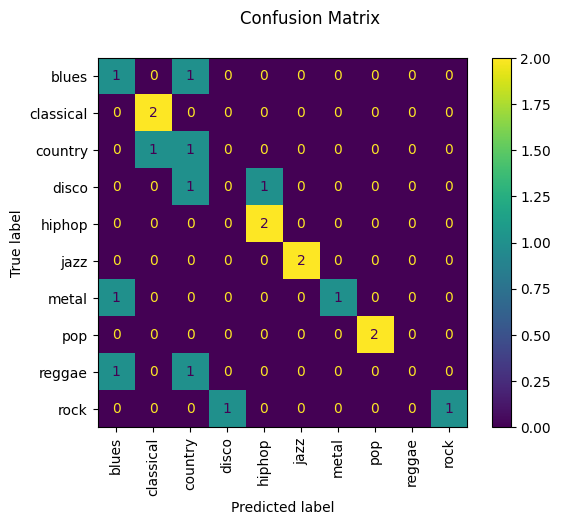

In [22]:
# Print the accuracy (again)
print('Accuracy on the test set: %.2f%%' % (metrics.accuracy_score(genre_test, genre_pred) * 100))

# Plot the confusion matrix
disp = metrics.ConfusionMatrixDisplay.from_predictions(genre_test, genre_pred, xticks_rotation = 'vertical')
disp.figure_.suptitle("Confusion Matrix")
plt.show()